Problem statement: A developer has contracted me to determine which building decisions are the most impactful to the value of a property.  I will examine the Ames housing data to identify factors of development that should be kept in mind as the developer seeks to effectively allocate resources.

Specifically: Basements?

In [1]:
#Imports
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error

data: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

#### missing vals

##### missing vals resources

https://medium.com/analytics-vidhya/how-to-handle-missing-values-cbd03fb79ef8#:~:text=When%20column%20has%20more%20than,%25%20missing%20value%2C%20drop%20it.

##### missing values analysis

In [2]:
df = pd.read_csv('../datasets/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [3]:
df.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,...,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,...,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,...,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [4]:
df.isnull().sum().sort_values(ascending = False)[lambda x:x>0]

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Qual        114
Garage Yr Blt      114
Garage Cond        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Area        22
Mas Vnr Type        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Area          1
Total Bsmt SF        1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
Garage Cars          1
dtype: int64

###### Column Dropping:

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651

There don't seem to be many pools in Ames.  I believe it is reasonable to drop this feature.  Likewise for Misc Feature, Alley, and Fence, these do not strike me as frequent enough and/or important enough to include as a predictive feature.  I will drop all four columns.

I'll drop PID because this would allow for an exact match to the sale price when training the model.  ID I will keep for now.

In [7]:
df.drop(columns = ['PID','Misc Feature','Alley','Fence','Pool QC', 'Pool Area'], axis = 1, inplace = True)

KeyError: "['PID' 'Misc Feature' 'Alley' 'Fence' 'Pool QC'] not found in axis"

In [11]:
df['Pool Area'].value_counts()

0      2042
519       1
576       1
800       1
228       1
480       1
648       1
738       1
368       1
561       1
Name: Pool Area, dtype: int64

Note: there are so few pools (9) that it would be difficult to draw conclusions from columns 'Pool QC' and 'Pool Area'.  I will drop these features from  the dataset that will be used for further analysis.

In [26]:
df.drop(columns = ['Pool QC', 'Pool Area'], inplace = True)

Per the data dictionary, I will replace NaN values in the data dictionary with 'None' as these buildings do not have a fence.

In [48]:
df.Fence.value_counts()

MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: Fence, dtype: int64

In [34]:
df.loc[df['Fence'].isna(),'Fence']="None"

There are a significant number of fireplaces and Na values for Fireplace Qu indicate no fireplace, so I will replace the missing values with ```'None'``` .

In [24]:
df.loc[df['Fireplaces']==0,'Fireplace Qu'] = "None"

0       None
1         TA
2       None
3       None
4       None
        ... 
2046      Gd
2047    None
2048      TA
2049      Gd
2050      TA
Name: Fireplace Qu, Length: 2051, dtype: object

In [47]:
df.loc[:, 'Misc Feature'].value_counts()

None    1986
Shed      56
Gar2       4
Othr       3
TenC       1
Elev       1
Name: Misc Feature, dtype: int64

Only 65 houses with misc features.  Shed is the most common of these with 56, but the median sale price is not much different (163_000.0 with no shed vs 153_750.0 with a shed)

In [34]:
df.isnull().sum().quantile([x/100 for x in range(90,100)]).values[0]

55.5

In [49]:
def pth_percentile_na(dataframe, pct = 10):
    thresh = df.isnull().sum().quantile([(100-pct)/100 for x in range(100-pct,100)])\
    .values[0]
    return [f'{col}: {df[col].isnull().sum()}' for col in df.columns if df[col].\
     isnull().sum() > thresh]
pth_percentile_na(df, 100)

['Mas Vnr Type: 22',
 'Mas Vnr Area: 22',
 'Bsmt Qual: 55',
 'Bsmt Cond: 55',
 'Bsmt Exposure: 58',
 'BsmtFin Type 1: 55',
 'BsmtFin SF 1: 1',
 'BsmtFin Type 2: 56',
 'BsmtFin SF 2: 1',
 'Bsmt Unf SF: 1',
 'Total Bsmt SF: 1',
 'Bsmt Full Bath: 2',
 'Bsmt Half Bath: 2',
 'Fireplace Qu: 1000',
 'Garage Type: 113',
 'Garage Yr Blt: 114',
 'Garage Finish: 114',
 'Garage Cars: 1',
 'Garage Area: 1',
 'Garage Qual: 114',
 'Garage Cond: 114']

I believe that in accordance with the format for other columns, the missing values for lot frontage likely indicate that the lot has no frontage.  This assumption is supported by the observation that the minimum recorded frontage is greater than zero. I will impute zeros in place of the NAs.

###### Imputing

In [24]:
df.loc[df['Lot Frontage'].isna(),'Lot Frontage'] = 0

(array([112., 203., 426., 492., 308., 109.,  39.,  18.,   6.,   3.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 21. ,  35.6,  50.2,  64.8,  79.4,  94. , 108.6, 123.2, 137.8,
        152.4, 167. , 181.6, 196.2, 210.8, 225.4, 240. , 254.6, 269.2,
        283.8, 298.4, 313. ]),
 <BarContainer object of 20 artists>)

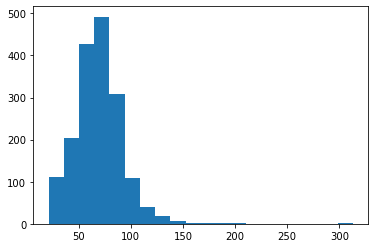

In [21]:
plt.hist(df.loc[df["Lot Frontage"]> 0, "Lot Frontage"],bins= 20)

I'll now have a look at the next batch of columns with null values.  These are 
```['Lot Frontage',
 'Garage Type',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond']```

In [37]:
df.loc[:,'Misc Feature'].value_counts()

Shed    56
Gar2     4
Othr     3
TenC     1
Elev     1
Name: Misc Feature, dtype: int64

Replace NAN for Fireplace Qu with 'None' where the num Fireplaces is 0.

In [13]:
df.loc[df['Fireplaces']==0,"Fireplace Qu"] = 'None'

In [61]:
# I will replace Alley access to None instead of NA, per the data dictionary description

In [14]:
df.loc[df["Alley"].isna()==True, 'Alley'] = "None"

Below, I replace NaN in Fireplace Qu with "None"

In [26]:
df.loc[df['Fireplaces']==0,'Fireplace Qu'] = 'None'

In [56]:
df.loc[df['Misc Feature'].isna(), 'Misc Feature'] = "None"
df.groupby('Misc Feature')['SalePrice'].median()

Misc Feature
Elev    183850.0
Gar2    148500.0
None    163000.0
Othr    186000.0
Shed    153750.0
TenC    250000.0
Name: SalePrice, dtype: float64

Gd    4
Fa    2
TA    2
Ex    1
Name: Pool QC, dtype: int64

In [19]:
df.isnull().sum().sort_values(ascending = False)[lambda x:x>0]

Fireplace Qu      1000
Lot Frontage       330
Garage Cond        114
Garage Yr Blt      114
Garage Finish      114
Garage Qual        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
Bsmt Qual           55
Bsmt Cond           55
BsmtFin Type 1      55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
BsmtFin SF 1         1
Garage Area          1
Garage Cars          1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
dtype: int64

In [15]:
pd.set_option('display.max_columns', None)
df["Alley"].unique()


array([nan, 'Pave', 'Grvl'], dtype=object)

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [10]:
df[df["Alley"].isna()==True].describe()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [16]:
df.groupby('Alley').mean()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
Alley,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Grvl,1662.847059,8.473912e+08,64.411765,59.296296,8487.141176,5.058824,5.952941,1921.294118,1970.082353,6.058824,135.658824,29.411765,617.152941,782.223529,926.388235,471.811765,20.423529,1418.623529,0.164706,0.070588,1.329412,0.176471,2.952941,1.082353,6.505882,0.317647,1944.901408,1.317647,345.811765,54.517647,45.458824,76.847059,0.000000,19.858824,0.000000,86.470588,6.294118,2007.564706,120835.635294
None,1466.965986,7.097315e+08,55.251177,70.367527,10263.277342,6.141811,5.551544,1973.765568,1984.448456,103.171338,460.571728,49.702618,563.671204,1073.945550,1180.138148,318.648875,4.506018,1503.293040,0.441069,0.064955,1.582941,0.375196,2.848770,1.041340,6.451596,0.612245,1979.716492,1.795288,479.105759,97.488749,46.406593,19.966510,2.664050,16.475667,2.573522,51.506541,6.230246,2007.785453,184366.258503
Pave,1427.800000,6.408712e+08,106.636364,43.666667,5622.036364,6.709091,5.327273,1978.163636,1997.018182,125.867925,281.690909,16.072727,632.236364,930.000000,988.690909,480.218182,17.454545,1486.363636,0.363636,0.000000,1.763636,0.527273,2.490909,1.036364,5.781818,0.272727,1989.490566,1.836364,482.563636,27.600000,90.763636,29.218182,4.072727,12.581818,0.000000,0.000000,5.745455,2007.763636,174534.709091


In [ ]:
df

In [116]:
df.groupby("Alley")

<bound method GroupBy.mean of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7fce72d986a0>>

Dealing with null values

In [67]:
df['Lot Frontage'].isna().sum()

330

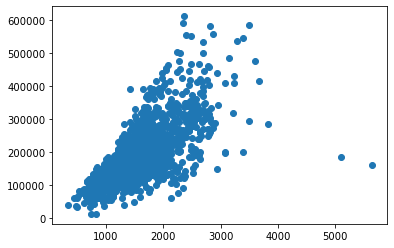

In [26]:
plt.scatter(df['Gr Liv Area'],df["SalePrice"])

There appear to be a couple outliers, so I will inspect these.  

In [39]:
df.loc[df['Gr Liv Area']>4000,:]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
960,1499,908154235,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,0,1,2008,New,160000
1885,2181,908154195,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,17000,10,2007,New,183850


In [84]:
ohe = OneHotEncoder(drop = 'if_binary', sparse = False, handle_unknown="ignore")

In [86]:
ohe.fit_transform(df["Lot Config"])

ValueError: Expected 2D array, got 1D array instead:
array=['CulDSac' 'CulDSac' 'Inside' ... 'Inside' 'Corner' 'Inside'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
import 

In [25]:
ctx = ColumnTransformer(
    transformers = [
        #('alias_first', actual_transformer, list_of_cols_to_apply_to)
        ('one_hot', ohe, ['Lot Config', 'Lot Shape', 'day', 'time'])
    ], remainder = 'passthrough', #don't drop the others
    verbose_feature_names_out = False
)

NameError: name 'ohe' is not defined

In [83]:
df['Lot Area'].isna().sum()

0

In [69]:
df['Lot Area'].describe()

count      2051.000000
mean      10065.208191
std        6742.488909
min        1300.000000
25%        7500.000000
50%        9430.000000
75%       11513.500000
max      159000.000000
Name: Lot Area, dtype: float64

In [79]:
df['Lot Config'].unique()

array(['CulDSac', 'Inside', 'Corner', 'FR2', 'FR3'], dtype=object)

In [ ]:
ohe

array(['CulDSac', 'Inside', 'Corner', 'FR2', 'FR3'], dtype=object)

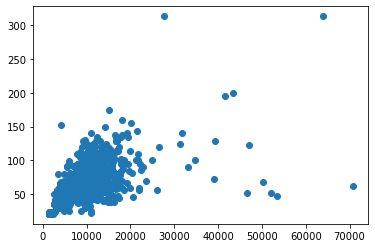

In [70]:
plt.scatter(x = df['Lot Area'], y = df['Lot Frontage'])
df["Lot Config"].unique()

idea: to get missing frontage values, regress the lot frontage on lot area, lot shape, and lot config

In [71]:
ohe = OneHotEncoder()

In [72]:
from sklearn.linear_model import LinearRegression

In [73]:
lr = LinearRegression()

In [ ]:
X_train_enc = pd.DataFrame(X_train_enc, columns = ctx.get_feature_names_out())
X_test_enc = pd.DataFrame(X_test_enc, columns = ctx.get_feature_names_out())

In [74]:
# one hot encoding explanation source:
# https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(values)
# print(integer_encoded)
# # binary encode
# onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# print(onehot_encoded)
# # invert first example
# inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
# print(inverted)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

onehot_encoded = onehot_encoder.fit_transform(df['MS SubClass'].values.reshape(1,-1))

print(onehot_encoded)

NameError: name 'onehot_encoder' is not defined

In [ ]:
sklearn.linear_model.LinearRegression(*, fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False)

In [ ]:
df.columns

baseline score:

In [57]:
df_traindf.iloc[:,0:-1]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0,11449,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,1011.0,Unf,0.0,873.0,1884.0,GasA,Ex,Y,SBrkr,1728,0,0,1728,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2007.0,Fin,2.0,520.0,TA,TA,Y,0,276,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD
2047,785,905377130,30,RL,NaN,12342,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,5,1940,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,262.0,Unf,0.0,599.0,861.0,GasA,Ex,Y,SBrkr,861,0,0,861,0.0,0.0,1,0,1,1,TA,4,Typ,0,NaN,Detchd,1961.0,Unf,2.0,539.0,TA,TA,Y,158,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD
2048,916,909253010,50,RL,57.0,7558,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1.5Fin,6,6,1928,1950,Gable,CompShg,BrkFace,Stone,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,896.0,896.0,GasA,Gd,Y,SBrkr,1172,741,0,1913,0.0,0.0,1,1,3,1,TA,9,Typ,1,TA,Detchd,1929.0,Unf,2.0,342.0,Fa,Fa,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD
2049,639,535179160,20,RL,80.0,10400,Pave,NaN,Reg,

In [51]:
X_train, X_val, y_train, y_val  = train_test_split(df.iloc[:,0:-1])


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
566,2710,905103140,80,RL,96.0,11777,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,SLvl,5,6,1966,1966,Gable,CompShg,VinylSd,VinylSd,BrkFace,97.0,TA,TA,CBlock,TA,TA,Av,LwQ,328.0,ALQ,551.0,285.0,1164.0,GasA,Ex,Y,SBrkr,1320,0,0,1320,1.0,0.0,1,0,3,1,TA,6,Typ,2,Fa,Attchd,1966.0,RFn,2.0,564.0,TA,TA,Y,160,68,240,0,0,0,NaN,NaN,NaN,0,5,2006,WD,164500
2025,2394,528142060,60,RL,82.0,10672,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Ex,TA,Gd,Unf,0.0,Unf,0.0,1054.0,1054.0,GasA,Gd,Y,SBrkr,1054,1335,0,2389,0.0,0.0,2,1,4,1,Gd,10,Typ,1,Gd,BuiltIn,2006.0,Fin,3.0,672.0,TA,TA,Y,176,64,0,0,0,0,NaN,NaN,NaN,0,11,2006,New,298236
1126,1175,533234020,60,FV,79.0,10646,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2001,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,513.0,TA,TA,PConc,TA,TA,No,GLQ,681.0,Unf,0.0,177.0,858.0,GasA,Ex,Y,SBrkr,872,917,0,1789,1.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,2001.0,Fin,2.0,546.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,223000
1455,1166,533213070,160,FV,24.0,2280,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,Twnhs,2Story,7,5,1999,1999,Gable,CompShg,MetalSd,MetalSd,BrkFace,360.0,TA,TA,PConc,Gd,TA,No,ALQ,549.0,Unf,0.0,195.0,744.0,GasA,Gd,Y,SBrkr,757,744,0,1501,0.0,0.0,2,1,3,1,TA,6,Typ,0,NaN,Detchd,1999.0,Unf,2.0,440.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2008,WD,179400
1052,1403,905401060,20,RL,NaN,53227,Pave,NaN,IR1,Low,AllPub,CulDSac,Mod,ClearCr,Norm,Norm,1Fam,1Story,4,6,1954,1994,Flat,Tar&Grv,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,BLQ,1116.0,Unf,0.0,248.0,1364.0,GasA,Ex,Y,SBrkr,1663,0,0,1663,1.0,0.0,1,0,2,1,Gd,6,Min1,2,Gd,Attchd,1954.0,Fin,2.0,529.0,TA,TA,Y,224,137,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,256000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,2625,535454030,90,RL,60.0,8544,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,Duplex,1Story,3,4,1950,1950,Gable,CompShg,BrkFace,Stone,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Fa,N,FuseF,1040,0,0,1040,0.0,0.0,2,0,2,2,TA,6,Typ,0,NaN,Detchd,1950.0,Unf,2.0,400.0,TA,Fa,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,81400
1983,990,526351030,20,RL,87.0,11029,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,8,1958,2002,Hip,CompShg,MetalSd,MetalSd,None,0.0,Ex,TA,CBlock,Gd,TA,No,ALQ,528.0,BLQ,411.0,245.0,1184.0,GasA,Ex,Y,SBrkr,1414,0,0,1414,1.0,0.0,1,0,3,1,TA,6,Min1,1,TA,Attchd,1990.0,Unf,2.0,601.0,TA,TA,Y,0,51,0,0,190,0,NaN,NaN,NaN,0,5,2008,WD,176500
866,509,528431070,20,RL,78.0,10206,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,PosN,Norm,1Fam,1Story,8,5,2008,2008,Gable,CompShg,VinylSd,VinylSd,BrkFace,294.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1614.0,1614.0,GasA,Ex,Y,SBrkr,1658,0,0,1658,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2008.0,Fin

data_dictionary:

|Feature|Type|Dataset|Description|
|---|---|---|---|
|Id|object|test_df|The state to which the observations pertain|
|MS|float|test_df|Proportion of the state's 2017 HS graduates who took the ACT| 

In [1]:
#Imports
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error

data: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

### Load the data

In [2]:
houses = pd.read_csv('../datasets/train.csv')
houses_test = pd.read_csv('../datasets/test.csv')
pd.set_option('display.max_columns', None)

In [3]:

houses.columns = [col.lower().replace(" ", '_') for col in \
                        houses.columns]
houses_test.columns = [col.lower().replace(' ','_') for col in \
                       houses_test.columns]

#### missing vals

##### missing vals resources

[how to handle missing values](https://medium.com/analytics-vidhya/how-to-handle-missing-values-cbd03fb79ef8#:~:text=When%20column%20has%20more%20than,%25%20missing%20value%2C%20drop%20it.)

##### missing values analysis

In [4]:
houses.describe()

,id,pid,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,saleprice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [5]:
houses.isnull().sum().sort_values(ascending = False)[lambda x:x>0]

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_qual        114
garage_yr_blt      114
garage_cond        114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_area        22
mas_vnr_type        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_area          1
total_bsmt_sf        1
bsmt_unf_sf          1
bsmtfin_sf_2         1
bsmtfin_sf_1         1
garage_cars          1
dtype: int64

###### Column Dropping:

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651

There don't seem to be many pools in Ames (9).  Likewise, only 65 houses have Miscelaneous Features (3.17%), so I believe it is reasonable to drop this feature.  Also, there are 1911 out of 2051 houses without an alley.  I'm going to remove this feature.  There are a significant number of fences (400), so I'll impute "None" for the NA values. It would be difficult to draw conclusions from columns 'Pool QC' and 'Pool Area', as there are only 9 houses with pools. 

Likewise for Misc Feature, Alley, and Fence, these do not strike me as frequent enough and/or important enough to include as a predictive feature.  I will drop all four columns.

I'll drop PID because this feature is reduntant with ID for data identification purposes.  ID I will keep for maintining identification of the data.  

In [6]:
dropped_columns = ['pid','misc_feature','alley','pool_qc', 'pool_area']
houses.drop(columns = dropped_columns, axis = 1, inplace = True)
houses_id = houses.pop('id')

In [8]:
houses_test.drop(columns = dropped_columns, axis = 1, inplace = True)
houses_test_id = houses_test.pop('id')

KeyError: "['pid' 'misc_feature' 'alley' 'pool_qc' 'pool_area'] not found in axis"

In [9]:
houses._get_numeric_data()

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,misc_val,mo_sold,yr_sold,saleprice
0,60,NaN,13517,6,8,1976,2005,289.0,533.0,0.0,192.0,725.0,725,754,0,1479,0.0,0.0,2,1,3,1,6,0,1976.0,2.0,475.0,0,44,0,0,0,0,3,2010,130500
1,60,43.0,11492,7,5,1996,1997,132.0,637.0,0.0,276.0,913.0,913,1209,0,2122,1.0,0.0,2,1,4,1,8,1,1997.0,2.0,559.0,0,74,0,0,0,0,4,2009,220000
2,20,68.0,7922,5,7,1953,2007,0.0,731.0,0.0,326.0,1057.0,1057,0,0,1057,1.0,0.0,1,0,3,1,5,0,1953.0,1.0,246.0,0,52,0,0,0,0,1,2010,109000
3,60,73.0,9802,5,5,2006,2007,0.0,0.0,0.0,384.0,384.0,744,700,0,1444,0.0,0.0,2,1,3,1,7,0,2007.0,2.0,400.0,100,0,0,0,0,0,4,2010,174000
4,50,82.0,14235,6,8,1900,1993,0.0,0.0,0.0,676.0,676.0,831,614,0,1445,0.0,0.0,2,0,3,1,6,0,1957.0,2.0,484.0,0,59,0,0,0,0,3,2010,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,20,79.0,11449,8,5,2007,2007,0.0,1011.0,0.0,873.0,1884.0,1728,0,0,1728,1.0,0.0,2,0,3,1,7,1,2007.0,2.0,520.0,0,276,0,0,0,0,1,2008,298751
2047,30,NaN,12342,4,5,1940,1950,0.0,262.0,0.0,599.0,861.0,861,0,0,861,0.0,0.0,1,0,1,1,4,0,1961.0,2.0,539.0,158,0,0,0,0,0,3,2009,82500
2048,50,57.0,7558,6,6,1928,1950,0.0,0.0,0.0,896.0,896.0,1172,741,0,1913,0.0,0.0,1,1,3,1,9,1,1929.0,2.0,342.0,0,0,0,0,0,0,3,2009,177000
2049,20,80.0,10400,4,5,1956,1956,0.0,155.0,750.0,295.0,1200.0,1200,0,0,1200,1.0,0.0,1,0,3,1,6,2,1956.0,1.0,294.0,0,189,140,0,0,0,11,2009,144000


For some columns that have NA values, the data dictionary indicates that the feature does not exist for the observation, as opposed to indicating that there was not any record.  The columns with na values that indicate the feature is not present for a given observation include:

Fence, FireplaceQu (and 'Fireplaces' ?), 

Garage Cond, Garage Qual, ('Garage Area' ?), Garage Cars, Garage Finish, Garage Yr Blt, Garage Type
Note: there is one fewer Garage Type NAs than there are NA's for the other garage features.  I need to investigate further.

Bsmt features are also asymetrically missing values, which needs to be investigated.  

Mas Vnr does not rely on NA's but instead has 'None' as a value to indicate if a feature is missing.  Imputing with the mode may be the best option here.



There are a significant number of fireplaces and Na values for Fireplace Qu indicate no fireplace, so I will replace the missing values with ```'None'``` .

Only 65 houses with misc features.  Shed is the most common of these with 56, but the median sale price is not much different (163,000.0 with no shed vs 153,750.0 with a shed)

In [10]:
houses.isnull().sum().quantile([x/100 for x in range(90,100)]).values[0]

91.00000000000047

In [11]:
# pct = 50
# houses.isnull().sum(
# .quantile([(100-x)/100 for x in range(100-pct,100)])

In [12]:
# def pth_percentile_na(dataframe, pct = 10):
#     thresh = houses.isnull().sum().quantile(
#         [(100-x)/100 for x in range(100-pct,100)]).values[0]
#     return [f'{col}: {houses[col].isnull().sum()}' for col in houses.columns if houses[col].\
#      isnull().sum() > thresh]
# pth_percentile_na(houses, 20)

I believe that in accordance with the format for other columns, the missing values for lot frontage likely indicate that the lot has no frontage.  This assumption is supported by the observation that the minimum recorded frontage is greater than zero. I will impute zeros in place of the NAs.

In [13]:
houses.isna().sum().value_counts()

0       52
1        6
114      4
55       3
22       2
2        2
330      1
58       1
56       1
1000     1
113      1
1651     1
dtype: int64

In [14]:
houses.dtypes

ms_subclass       int64
ms_zoning        object
lot_frontage    float64
lot_area          int64
street           object
                 ...   
misc_val          int64
mo_sold           int64
yr_sold           int64
sale_type        object
saleprice         int64
Length: 75, dtype: object

In [15]:
#https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-
#pandas
#https://stackoverflow.com/questions/21271581/selecting-pandas-columns-by-dtype

houses_numeric = houses.select_dtypes(exclude=[object])
si = SimpleImputer(strategy = 'constant')

si.fit(houses_numeric)
houses_numeric_imputed = si.transform(houses_numeric)
houses_numeric = pd.DataFrame(houses_numeric_imputed, columns = houses_numeric.\
                              columns)

houses_obj = houses.select_dtypes(include=[object])
si = SimpleImputer(strategy = 'constant', fill_value='None')

si.fit(houses_obj)
houses_obj_imputed = si.transform(houses_obj)
houses_obj = pd.DataFrame(houses_obj_imputed, columns = houses_obj.\
                              columns)
houses_imp = houses_numeric.join(houses_obj)

houses_imp.describe()

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,misc_val,mo_sold,yr_sold,saleprice
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,57.008776,57.944417,10065.208191,6.112140,5.562165,1971.708922,1984.190151,98.626524,442.084837,47.935641,567.451487,1057.471965,1164.488055,329.329108,5.512921,1499.330083,0.427109,0.063384,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1868.725987,1.775719,473.440761,93.833740,47.556802,22.571916,2.591419,16.511458,51.574354,6.219893,2007.775719,181469.701609
std,42.824223,33.137332,6742.488909,1.426271,1.104497,30.177889,21.036250,174.324690,461.195041,164.964052,445.022846,449.908003,396.446923,425.671046,51.068870,500.447829,0.522589,0.251590,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,454.133654,0.765357,216.135102,128.549416,66.747241,59.845110,25.229615,57.374204,573.393985,2.744736,1.312014,79258.659352
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,43.500000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,50.000000,63.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.000000,994.000000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,70.000000,78.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,159.000000,733.500000,0.000000,811.000000,1318.500000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,17000.000000,12.000000,2010.000000,611657.000000


In [16]:
# imputing test data
houses_test_numeric = houses_test.select_dtypes(exclude=[object])
si = SimpleImputer(strategy = 'constant')
si.fit(houses_test_numeric)
houses_test_numeric_imputed = si.transform(houses_test_numeric)
houses_test_numeric = pd.DataFrame(houses_test_numeric_imputed, columns = houses_test_numeric.\
                              columns)

houses_test_obj = houses_test.select_dtypes(include=[object])
si = SimpleImputer(strategy = 'constant', fill_value='None')

si.fit(houses_test_obj)
houses_test_obj_imputed = si.transform(houses_test_obj)
houses_test_obj = pd.DataFrame(houses_test_obj_imputed, columns = houses_test_obj.\
                              columns)
houses_test_imp = houses_test_numeric.join(houses_test_obj)

houses_test_imp.describe()

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,misc_val,mo_sold,yr_sold
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,58.268793,56.872437,10307.033030,6.050114,5.566059,1970.492027,1984.417995,106.115034,441.328018,53.896355,539.133257,1034.357631,1145.787016,348.398633,2.728929,1496.914579,0.439636,0.055809,1.539863,0.398633,2.879271,1.047836,6.454442,0.618451,1875.445330,1.742597,470.362187,93.430524,47.070615,24.064920,2.597950,14.830296,48.498861,6.202733,2007.825740
std,42.235407,34.269502,10002.674602,1.369065,1.128903,30.395895,20.450725,187.086530,438.457329,178.632355,426.172161,413.446291,375.264111,432.985566,32.572548,506.468967,0.529948,0.229683,0.559060,0.505927,0.830712,0.223966,1.596632,0.669571,436.866917,0.750391,212.734075,121.181702,68.180939,73.249463,24.962482,53.003794,550.169317,2.642498,1.327861
min,20.000000,0.000000,1477.000000,2.000000,1.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,40.000000,7297.250000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,216.000000,789.000000,864.000000,0.000000,0.000000,1114.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,322.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,60.000000,9446.000000,6.000000,5.000000,1972.000000,1992.000000,0.000000,373.000000,0.000000,452.000000,975.000000,1063.000000,0.000000,0.000000,1436.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1976.500000,2.000000,473.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,78.000000,11589.000000,7.000000,6.000000,1999.750000,2003.000000,171.750000,734.750000,0.000000,780.000000,1247.000000,1358.000000,720.000000,0.000000,1779.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2000.000000,2.000000,576.000000,170.750000,69.750000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,182.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,2288.000000,1526.000000,2046.000000,2630.000000,2674.000000,2065.000000,481.000000,4476.000000,2.000000,1.000000,4.000000,2.000000,6.000000,3.000000,12.000000,3.000000,2010.000000,4.000000,1488.000000,690.000000,742.000000,1012.000000,360.000000,576.000000,15500.000000,12.000000,2010.000000


In [17]:
def zero_counts(dataframe):
    zero_counts_dict = {col:dataframe.loc[dataframe[col]==0,col].count() \
               for col in dataframe.columns}
    zero_counts_df = pd.DataFrame.from_dict(data = zero_counts_dict, \
                                            orient = 'index',\
                                            columns = ['zero_counts'])
    zero_counts_df_sorted = zero_counts_df.sort_values(by = 'zero_counts', \
                                                       ascending = False)
    return zero_counts_df_sorted.loc[zero_counts_df_sorted['zero_counts']>0,:]

zero_counts(houses_imp)


,zero_counts
3ssn_porch,2025
low_qual_fin_sf,2018
misc_val,1986
bsmt_half_bath,1925
screen_porch,1870
bsmtfin_sf_2,1804
enclosed_porch,1724
half_bath,1308
mas_vnr_area,1238
bsmt_full_bath,1202


In [18]:
# https://stackoverflow.com/questions/1007481/how-to-replace-whitespaces-with-\
# underscore
# https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/

# rename_dict = dict(map(lambda i,j : (i,j) , houses_imp.columns,[col.replace(' ','_') for col in houses_imp.columns]))

# houses_imp.columns

In [19]:
import numpy as np

In [86]:
def ft_price_sd(df,features,target):
    target_sd_by_feature =  {feat:np.std(df.groupby([feat])[target].mean().values)\
            for feat in features}
    return pd.DataFrame.from_dict(target_sd_by_feature, orient='index', columns\
            = ['target_sd']).sort_values(by = 'target_sd', ascending = False)

cat_price_sd = ft_price_sd(houses_imp, houses_obj.columns, 'saleprice')


In [94]:
cat_price_sd

,target_sd
condition_2,112416.338996
exter_qual,107679.802091
kitchen_qual,89597.529503
bsmt_qual,83220.946312
garage_qual,72754.521542
exter_cond,66754.802867
fireplace_qu,66203.400248
neighborhood,65776.772939
ms_zoning,61551.176103
roof_matl,61035.047243


[plotting ref1](https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot)
[plotting ref2](https://www.reddit.com/r/learnpython/comments/3cjnpg/seaborn_xaxis_as_index/)

[Text(0, 0.5, 'Categorical Feature'), Text(0.5, 0, 'Price Standard Deviation')]

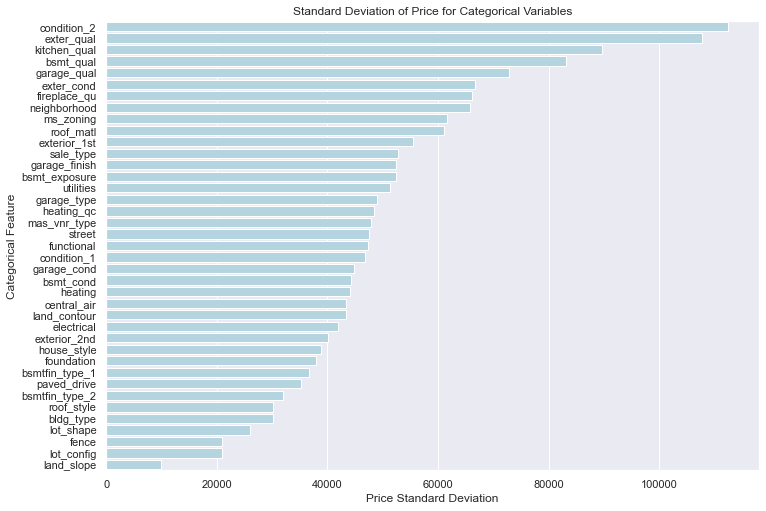

In [127]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

p1 = sns.barplot(data = cat_price_sd.reset_index(), x = 'target_sd', y = 'index', \
            color = 'lightblue')
p1.set(title = 'Standard Deviation of Price for Categorical Variables')
p1.set(ylabel = 'Categorical Feature', xlabel = 'Price Standard Deviation')

AttributeError: 'AxesSubplot' object has no property 'color'

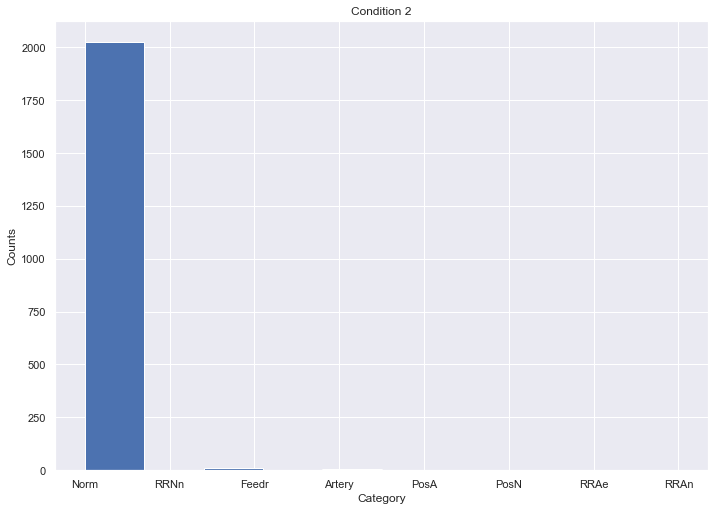

In [125]:
houses_imp.groupby('condition_2').mean()['saleprice']

houses_imp['condition_2'].hist().set(title='Condition 2', xlabel='Category', \
                                     ylabel = 'Counts', color = 'lightblue')
houses_imp['condition_2'].value_counts()

Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	

In [21]:
houses

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,fence,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,60,RL,NaN,13517,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,NaN,0,3,2010,WD,130500
1,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,NaN,0,4,2009,WD,220000
2,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,NaN,0,1,2010,WD,109000
3,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,NaN,0,4,2010,WD,174000
4,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,NaN,0,3,2010,WD,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,20,RL,79.0,11449,Pave,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,1011.0,Unf,0.0,873.0,1884.0,GasA,Ex,Y,SBrkr,1728,0,0,1728,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2007.0,Fin,2.0,520.0,TA,TA,Y,0,276,0,0,0,NaN,0,1,2008,WD,298751
2047,30,RL,NaN,12342,Pave,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,5,1940,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,262.0,Unf,0.0,599.0,861.0,GasA,Ex,Y,SBrkr,861,0,0,861,0.0,0.0,1,0,1,1,TA,4,Typ,0,NaN,Detchd,1961.0,Unf,2.0,539.0,TA,TA,Y,158,0,0,0,0,NaN,0,3,2009,WD,82500
2048,50,RL,57.0,7558,Pave,Reg,Bnk,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,1.5Fin,6,6,1928,1950,Gable,CompShg,BrkFace,Stone,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,896.0,896.0,GasA,Gd,Y,SBrkr,1172,741,0,1913,0.0,0.0,1,1,3,1,TA,9,Typ,1,TA,Detchd,1929.0,Unf,2.0,342.0,Fa,Fa,Y,0,0,0,0,0,NaN,0,3,2009,WD,177000
2049,20,RL,80.0,10400,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1956,1956,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,155.0,LwQ,750.0,295.0,1200.0,GasA,TA,Y,SBrkr,1200,0,0,1200,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1956.0,Unf,1.0,29

In [22]:
X = houses_imp.drop(columns = ['saleprice'])
y = houses_imp['saleprice']

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = .25,
    random_state = 3
)

In [24]:
ohe = OneHotEncoder(
    drop = 'if_binary',
    handle_unknown = 'ignore',
    sparse = False
)

In [25]:
ctx = ColumnTransformer(
    transformers = [
        #('alias_first', actual_transformer, list_of_cols_to_apply_to)
        ('one_hot', ohe, houses.select_dtypes(include = ['object']).columns)
    ], remainder = 'passthrough', #don't drop the others
    verbose_feature_names_out = False
)

In [26]:
#transform train
ctx.fit(X_train)
X_train_enc = ctx.transform(X_train)

#transform test
X_val_enc = ctx.transform(X_val)

#recreate dataframes
X_train_enc = pd.DataFrame(X_train_enc, columns = ctx.get_feature_names_out())
X_val_enc = pd.DataFrame(X_val_enc, columns = ctx.get_feature_names_out())

X_train_enc.shape, X_val_enc.shape


/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 7, 9, 13, 20] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


((1538, 279), (513, 279))

In [150]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train_enc)
Xs_train = pd.DataFrame(Xs_train, columns = ss.get_feature_names_out())
Xs_val = pd.DataFrame(ss.transform(X_val_enc), columns = ss.get_feature_names_out())

In [66]:
lr = LinearRegression()
lr.fit(Xs_train_enc, y_train)
lr.score(X_train_enc, y_train), lr.score(X_val_enc, y_val)

(0.9468912295201589, 0.7766178664910439)

The baseline Linear regression model massively overfits the data.

In [172]:
linear_preds = lr.predict(Xs_val)

[RMSE formula](https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python)

In [175]:
from sklearn.metrics import mean_squared_error

def RMSE(y_real, y_pred):
    rms = mean_squared_error(y_real, y_pred, squared=False)
    return round(rms**.5,2)

In [176]:
linear_preds = lr.predict(Xs_val)
RMSE(y_val, linear_preds)

379229312.25

The RMSE for the standard, unregularized linear regression is significantly worse than baseline.  It comes out to $379,229,312.25



In [67]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

Baseline Model will predict the y validation based on the average of the y train.

In [141]:
pred_b = y_train.mean()

round((sum((y_val - pred_b).pow(2))/len(y_val))**.5,2)

79420.42

The baseline rmse for the validation set is $79,420.42

In [66]:
lr = LinearRegression()
lr.fit(Xs_train_enc, y_train)
lr.score(X_train_enc, y_train), lr.score(X_val_enc, y_val)

(0.9468912295201589, 0.7766178664910439)

In [164]:
en = ElasticNetCV(l1_ratio=np.arange(.9,1,.001))


In [166]:
en.fit(Xs_train, y_train)
en.score(Xs_val,y_val)
best_alpha, best_l1_ratio = en.alpha_, en.l1_ratio_
best_alpha, best_l1_ratio, en.score(Xs_val,y_val), en.score(Xs_train,y_train)


(224.20802286372017,
 0.9990000000000001,
 0.8472048283097426,
 0.9347147738452156)

After adjusting the l1_ratio for ElasticNet, the best l1 ratio approaches 1 indicating that the lasso is the best model.  I will use the lasso moving forward.

In [163]:
en.score(Xs_train, y_train), en.score(Xs_val, y_val)

(0.9347147738452156, 0.8472048283097426)

In [74]:
best_alpha 

0.6309999999999999

In [179]:
en.fit(pd.concat([Xs_train,Xs_val]), pd.concat([y_train,y_val]))
en.alpha_

338.5203902449057

In [182]:
en.alpha_, en.l1_ratio_

(338.5203902449057, 0.9990000000000001)

In [193]:
en.feature_names_in_

array([-7.57543213e+03, -2.97946756e+03, -2.50552917e+03, -2.01291774e+03,
       -1.66989334e+03, -1.61923135e+03, -1.46328280e+03, -1.45455191e+03,
       -1.38200958e+03, -1.23467490e+03, -1.07566490e+03, -1.06130239e+03,
       -1.04897678e+03, -9.90727972e+02, -9.66920254e+02, -9.66375696e+02,
       -9.24123631e+02, -9.01882817e+02, -8.99310367e+02, -8.96333029e+02,
       -8.72044057e+02, -8.59966754e+02, -8.14538858e+02, -7.84139170e+02,
       -7.68266554e+02, -7.27612560e+02, -7.25931167e+02, -7.25693846e+02,
       -7.24555436e+02, -7.22666232e+02, -6.93827566e+02, -6.87187216e+02,
       -6.68219779e+02, -6.13034278e+02, -6.01901883e+02, -5.93946644e+02,
       -5.86502180e+02, -5.79305881e+02, -5.64273337e+02, -5.58681578e+02,
       -5.34733106e+02, -5.14685355e+02, -4.76777981e+02, -4.50324692e+02,
       -4.27023152e+02, -4.10379521e+02, -4.04957928e+02, -4.01532044e+02,
       -3.85153410e+02, -3.79914643e+02, -3.71328876e+02, -3.70705250e+02,
       -3.56819699e+02, -

In [52]:
houses_test_imp_enc = ctx.transform(houses_test_imp)
houses_test_imp_enc_ss = pd.DataFrame(ss.transform(houses_test_imp_enc), columns = ss.get_feature_names_out())

/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 13, 14, 15, 16, 20, 25, 28, 29, 38] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/william/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [3]:

en_preds2 = en.predict(houses_test_imp_enc_ss)

en_preds2 = pd.DataFrame(en_preds1,columns = ['SalePrice'])

en_preds2.insert(loc = 0, column = 'Id', value = houses_test_id)

en_preds2.to_csv('./en_2_simple.csv', index = False)

ss.inversetransform(en_preds2.coef_)

NameError: name 'en' is not defined